Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = './data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
# Taking the code from previous exercise & adding optimization 
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases

  # ADDING REGULARIZATION TERM
  beta = tf.placeholder(tf.float32)

  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + 
    beta * tf.nn.l2_loss(weights)) # beta * 1/2 * ||w||^2
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)


In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-2} 
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 48.701633
Minibatch accuracy: 6.2%
Validation accuracy: 10.6%
Minibatch loss at step 500: 0.746653
Minibatch accuracy: 86.7%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 0.800058
Minibatch accuracy: 80.5%
Validation accuracy: 81.3%
Minibatch loss at step 1500: 0.566515
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 0.648468
Minibatch accuracy: 88.3%
Validation accuracy: 81.2%
Minibatch loss at step 2500: 0.782561
Minibatch accuracy: 78.9%
Validation accuracy: 81.1%
Minibatch loss at step 3000: 0.784396
Minibatch accuracy: 80.5%
Validation accuracy: 81.4%
Test accuracy: 88.6%


Beta parameter has to be tuned: run the following code and plot accuracy to tune beta

In [7]:
beta_vals = np.logspace(-4, -1, num = 10)
validation_acc = []

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
    
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_val} 
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        validation_acc.append(accuracy(test_prediction.eval(), test_labels))

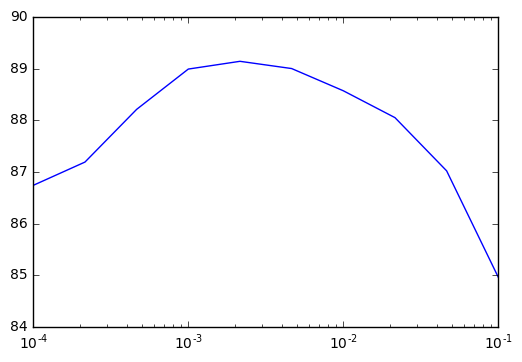

In [8]:
# Plot the accuracy
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogx(beta_vals, validation_acc)
plt.show()

# Seems like 1e-3 is the best accuracy we can do 

Now doing the same thing for neural network implementation

In [9]:
batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data portion is the same as before 
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables: turn into weights -> relu -> weights 
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))

  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation: insert relu's 
  relu_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(relu_train, weights_2) + biases_2

  beta = tf.placeholder(tf.float32)
  loss = (tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + 
    beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2)))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_relu, weights_2) + biases_2)
  test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights_2) + biases_2)

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 659.898926
Minibatch accuracy: 5.5%
Validation accuracy: 24.1%
Minibatch loss at step 500: 200.913437
Minibatch accuracy: 82.0%
Validation accuracy: 78.8%
Minibatch loss at step 1000: 115.125145
Minibatch accuracy: 78.9%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 68.987320
Minibatch accuracy: 89.1%
Validation accuracy: 83.0%
Minibatch loss at step 2000: 41.260166
Minibatch accuracy: 88.3%
Validation accuracy: 84.8%
Minibatch loss at step 2500: 25.191193
Minibatch accuracy: 87.5%
Validation accuracy: 85.5%
Minibatch loss at step 3000: 15.445206
Minibatch accuracy: 83.6%
Validation accuracy: 86.6%
Test accuracy: 93.2%


In [11]:
beta_vals = np.logspace(-4, -1, num = 10)
validation_acc = []

for beta_val in beta_vals:
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
    
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : beta_val} 
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            
        validation_acc.append(accuracy(test_prediction.eval(), test_labels))

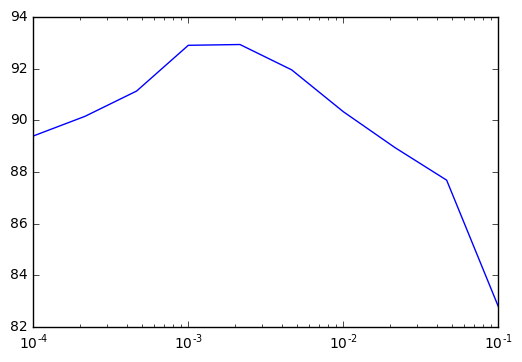

In [12]:
# Plot the accuracy
plt.semilogx(beta_vals, validation_acc)
plt.show()

# Seems like 1e-3 is the best accuracy we can do 

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [18]:
num_steps = 501
num_batches = 4

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step % batch_size) 
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 652.010010
Minibatch accuracy: 14.1%
Validation accuracy: 36.0%
Minibatch loss at step 50: 299.214691
Minibatch accuracy: 100.0%
Validation accuracy: 66.4%
Minibatch loss at step 100: 284.569122
Minibatch accuracy: 100.0%
Validation accuracy: 68.4%
Minibatch loss at step 150: 270.687347
Minibatch accuracy: 100.0%
Validation accuracy: 68.9%
Minibatch loss at step 200: 257.482422
Minibatch accuracy: 100.0%
Validation accuracy: 68.9%
Minibatch loss at step 250: 244.921951
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 300: 232.974121
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 350: 221.608734
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 400: 210.798203
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 450: 200.515137
Minibatch accuracy: 100.0%
Validation accuracy: 69.0%
Minibatch loss at step 500: 190.733337
Minibatch accuracy: 100

The minibatch accuracy is at 100%, while the validation and test accuracy are significantly lower. This indicates overfitting.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [20]:

batch_size = 128
hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data portion is the same as before 
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables: turn into weights -> relu -> weights 
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))

  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation: insert relu's 
  relu_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  dropout = tf.nn.dropout(relu_train, 0.5)
  logits = tf.matmul(dropout, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_relu = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_relu, weights_2) + biases_2)
  test_relu = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_prediction = tf.nn.softmax(tf.matmul(test_relu, weights_2) + biases_2)

In [22]:
num_steps = 501
num_batches = 4

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step % batch_size) 
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 445.774902
Minibatch accuracy: 10.2%
Validation accuracy: 27.7%
Minibatch loss at step 50: 1.034931
Minibatch accuracy: 99.2%
Validation accuracy: 70.6%
Minibatch loss at step 100: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 71.6%
Minibatch loss at step 150: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.5%
Minibatch loss at step 200: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.5%
Minibatch loss at step 250: 1.235884
Minibatch accuracy: 99.2%
Validation accuracy: 73.6%
Minibatch loss at step 300: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.2%
Minibatch loss at step 350: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 73.7%
Minibatch loss at step 400: 0.169040
Minibatch accuracy: 99.2%
Validation accuracy: 74.8%
Minibatch loss at step 450: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 74.3%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy

Here there is still a case of overfitting as most of the minibatch accuracy is set at 100%, but not all. This neural net is bit more general and has a better test accuracy.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [38]:
batch_size = 128
hidden_nodes = 1024
hidden_nodes2 = 512
beta = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data portion is the same as before 
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)
  
  # Variables
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes],
                       stddev=np.sqrt(2.0 / (image_size * image_size))))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))

  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, hidden_nodes2], stddev=np.sqrt(2.0 / hidden_nodes)))
  biases_2 = tf.Variable(tf.zeros([hidden_nodes2]))

  weights_3 = tf.Variable(
    tf.truncated_normal([hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / hidden_nodes2)))
  biases_3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation: insert relu's 
  layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  layer2 = tf.nn.relu(tf.matmul(layer1, weights_2) + biases_2)
  logits = tf.matmul(layer2, weights_3) + biases_3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
    beta * (tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.1, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(0.3).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_layer1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1)
  valid_layer2 = tf.nn.relu(tf.matmul(valid_layer1, weights_2) + biases_2)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_layer2, weights_3) + biases_3)

  test_layer1 = tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1)
  test_layer2 = tf.nn.relu(tf.matmul(test_layer1, weights_2) + biases_2)
  test_prediction = tf.nn.softmax(tf.matmul(test_layer2, weights_3) + biases_3)

In [39]:
num_steps = 9001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.517687
Minibatch accuracy: 16.4%
Validation accuracy: 35.6%
Minibatch loss at step 500: 1.272588
Minibatch accuracy: 89.1%
Validation accuracy: 85.7%
Minibatch loss at step 1000: 1.177266
Minibatch accuracy: 85.9%
Validation accuracy: 86.4%
Minibatch loss at step 1500: 0.799434
Minibatch accuracy: 93.8%
Validation accuracy: 87.7%
Minibatch loss at step 2000: 0.688862
Minibatch accuracy: 93.8%
Validation accuracy: 88.0%
Minibatch loss at step 2500: 0.684691
Minibatch accuracy: 90.6%
Validation accuracy: 88.0%
Minibatch loss at step 3000: 0.654243
Minibatch accuracy: 88.3%
Validation accuracy: 88.4%
Minibatch loss at step 3500: 0.651992
Minibatch accuracy: 86.7%
Validation accuracy: 88.5%
Minibatch loss at step 4000: 0.496784
Minibatch accuracy: 92.2%
Validation accuracy: 88.8%
Minibatch loss at step 4500: 0.498756
Minibatch accuracy: 89.8%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 0.527769
Minibatch accuracy: 89.8%
Validation accurac